In [1]:
%reset -f
!pyclean .

^C


Cleaning directory .
Total 2 files, 1 directories removed.


In [ ]:
from utils import *
%matplotlib inline

In [ ]:
image_path = os.path.join(IMAGES_DIRECTORY, "00a2e221a62f5c98c116f977ee4a447d.png")

In [ ]:
preprocess_image(image_path)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.47306925, 0.50140053, 0.60114044],
         [0.6161465 , 0.62084836, 0.68813527],
         [0.6713485 , 0.6667667 , 0.7093438 ],
         ...,
         [0.6638642 , 0.68021065, 0.6945768 ],
         [0.54839915, 0.56330514, 0.61556613],
         [0.6417195 , 0.6531842 , 0.67707175]],
 
        [[0.6481193 , 0.6584834 , 0.7077831 ],
         [0.70952386, 0.7031613 , 0.73957586],
         [0.7445178 , 0.73919564, 0.7663465 ],
         ...,
         [0.6832343 , 0.6829341 , 0.71682763],
         [0.71278524, 0.7114847 , 0.73753506],
         [0.59679395, 0.6182035 , 0.6467756 ]],
 
        [[0.73819524, 0.73819524, 0.7646259 ],
         [0.7347139 , 0.7234694 , 0.7430772 ],
         [0.787335  , 0.7864346 , 0.79847944],
         ...,
         [0.7070044 , 0.7061638 , 0.6957399 ],
         [0.63941526, 0.6315921 , 0.66212445],
         [0.45956078, 0.49643794, 0.54899764]],
 
        ...,
 
        [[0.3339935 , 0.32773107

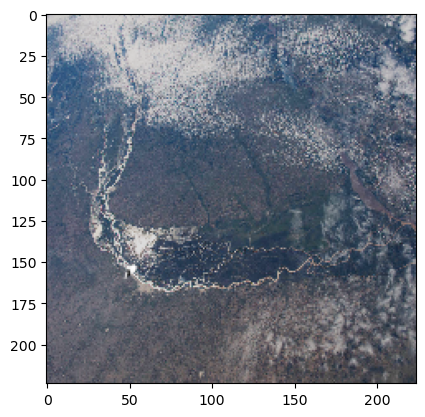

In [ ]:
plt.imshow(preprocess_image(image_path)[0].numpy())

In [ ]:
DATA_DIRECTORY

'D:\\spacecraft\\data'

In [ ]:
metadata = pd.read_csv(os.path.join(DATA_DIRECTORY, "train_metadata.csv"))

In [ ]:
metadata.head(1)

,image_id,spacecraft_id,background_id
0,0001954c9f4a58f7ac05358b3cda8d20,24,247


In [ ]:
len(np.unique(metadata.background_id))

204

In [ ]:
bbox = pd.read_csv(os.path.join(DATA_DIRECTORY, "train_labels.csv"), index_col="image_id")
image_list = [i.split(".")[0] for i in os.listdir(IMAGES_DIRECTORY)]
bbox = bbox[bbox.index.to_series().apply(lambda x: x in image_list)]

In [ ]:
bbox.head(1)

,xmin,ymin,xmax,ymax
image_id,,,,
000dbf763348037b46558bbcb6a032ac,160,434,203,481


In [ ]:
def get_bbox(image_id, labels):
    """Get bbox coordinates as list from dataframe for given image id."""
    return labels.loc[image_id].loc[["xmin", "ymin", "xmax", "ymax"]].values.tolist()

def display_image(image_id, images_dir=IMAGES_DIRECTORY, show_bbox=False, labels=bbox):
    """Display image given image ID. Annotate with bounding box if `show_bbox` is True."""
    img = cv2.imread(str(images_dir + f"//{image_id}.png"))
    fig, ax = plt.subplots()
    ax.imshow(np.flip(img, axis=-1))

    if show_bbox:
        xmin, ymin, xmax, ymax = get_bbox(image_id, labels)
        patch = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='white', linewidth=1)
        ax.add_patch(patch)

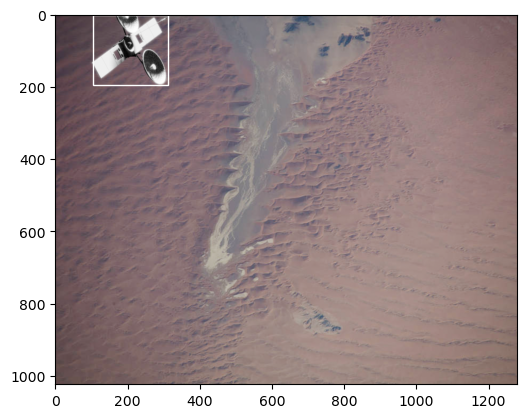

In [ ]:
display_image("000f13aff94499d03e3997afc55b0aa0", show_bbox=True)

In [ ]:
os.listdir(IMAGES_DIRECTORY)

['000dbf763348037b46558bbcb6a032ac.png',
 '000e79208bebd8e84ce6c22fd8612a0d.png',
 '000f13aff94499d03e3997afc55b0aa0.png',
 '00a2e221a62f5c98c116f977ee4a447d.png',
 '00a5abac1b2784e032c6c4d26db5d57f.png',
 '00a6e3e5280453302ddf5fe174fba37b.png',
 '00a9b9394502c46d499db834a7561ff7.png',
 '00a257cb17325152e35c0ccd17e3ad51.png']

In [ ]:
train_paths = [IMAGES_DIRECTORY + "\\" +i for i in os.listdir(IMAGES_DIRECTORY)]
train_labels = [[row["xmin"], row["ymin"], row["xmax"], row["ymax"]] for _, row in bbox.iterrows()]

In [ ]:
batch_size = 8
def load_image_and_labels(image_path, bbox):
    # Load and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image /= 255.0  # Normalize to [0,1]
    
    return image, bbox

# Assuming you have a function to split your dataset into train_paths and train_labels
train_dataset1 = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset1.map(load_image_and_labels).batch(batch_size)

In [ ]:
train_dataset1

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(4,), dtype=tf.int32, name=None))>

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)
base_model.trainable = True  # Use as feature extractor

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4)  # Assuming one bounding box per image; [x_min, y_min, x_max, y_max]
])


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 2,228,996
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(train_dataset, epochs=200)

Epoch 1/200


1/1 [==============================] - 5s 5s/step - loss: 206746.0000
Epoch 2/200
1/1 [==============================] - 0s 60ms/step - loss: 204961.3438
Epoch 3/200
1/1 [==============================] - 0s 69ms/step - loss: 202835.3125
Epoch 4/200
1/1 [==============================] - 0s 64ms/step - loss: 200530.0938
Epoch 5/200
1/1 [==============================] - 0s 64ms/step - loss: 198435.0469
Epoch 6/200
1/1 [==============================] - 0s 69ms/step - loss: 196592.1250
Epoch 7/200
1/1 [==============================] - 0s 69ms/step - loss: 194909.3750
Epoch 8/200
1/1 [==============================] - 0s 70ms/step - loss: 193300.7812
Epoch 9/200
1/1 [==============================] - 0s 72ms/step - loss: 191841.3438
Epoch 10/200
1/1 [==============================] - 0s 70ms/step - loss: 190497.3750
Epoch 11/200
1/1 [==============================] - 0s 69ms/step - loss: 189242.8750
Epoch 12/200
1/1 [==============================] - 0s 65ms/step - loss: 188119.0938
Epo

In [ ]:
# Example of predicting a bounding box for a new image
test_image, _ = load_image_and_labels(os.path.join(IMAGES_DIRECTORY,"000f13aff94499d03e3997afc55b0aa0.png"), [0, 0, 0, 0])  # Dummy bbox
test_image = tf.expand_dims(test_image, 0)  # Add batch dimension

predicted_bbox = model.predict(test_image)
print("Predicted bounding box:", predicted_bbox)

1/1 [==============================] - 0s 24ms/step
Predicted bounding box: [[ 10.704969    7.1014833   3.1477084 -10.029707 ]]


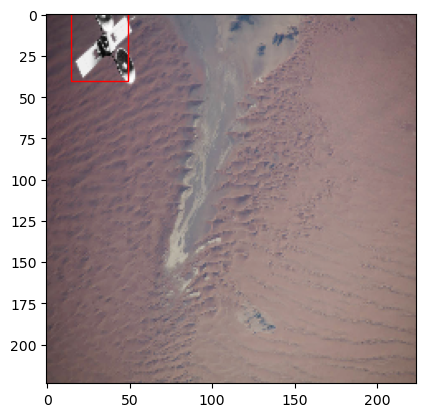

In [ ]:
predicted_bbox = np.squeeze(predicted_bbox)  # Remove batch dimension if present

x_min, y_min, x_max, y_max = predicted_bbox
x_min = x_min*1024/224
x_max = x_max*1024/224
y_min = y_min*1280/224
y_max = y_max*1280/224


# Plotting
fig, ax = plt.subplots(1)
# Display the image
ax.imshow(test_image[0,:,:,:])

# Create a Rectangle patch
rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

`not bad` but how can I add the percentage my model predict that is a satellite?
I need to add more element to my model now
- add segmentation
- add callbacks
- add probability